In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
# print(IN_COLAB)

if IN_COLAB:
    !rm -rf ISLP
    !git clone https://github.com/ssuai/ISLP.git
    #!pip install ISLP # This takes too much time

Cloning into 'ISLP'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 63 (delta 14), reused 53 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (63/63), 2.34 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (14/14), done.


In this lab, we use the `sklearn.svm` library to demonstrate the support
vector classifier and the support vector machine.

We  import some of our usual libraries.

In [2]:
import numpy as np
import statsmodels.api as sm
from matplotlib.pyplot import subplots, cm
import seaborn as sns

We also collect the new imports
needed for this lab.

In [3]:
import sklearn.model_selection as skm
from sklearn.svm import SVC, SVR
from sklearn.metrics import RocCurveDisplay
import sklearn.linear_model as skl

from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

from ISLP.utils import load_data, confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP.svm import plot as plot_svm
from functools import partial
from statsmodels.api import OLS

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
# safer way to install l0bnb
try:
    from l0bnb import fit_path
except ImportError:
    import sys
    !{sys.executable} -m pip install l0bnb
    !{sys.executable} -m pip install numpy==1.26.4      # l0bnb does not work with numpy 2.X
    from l0bnb import fit_path
# !pip install l0bnb
# from l0bnb import fit_path

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-none-any.whl size=22296 sha256=3608f907f0e1bebc005fafb7a96aec76342d69bb1718f8116e98d46317663626
  Stored in directory: /root/.cache/pip/wheels/56/b6/7a/2a78772d92aa67f0d038759a09c7e950b5a708d5ecd5c0e38d
Successfully built l0bnb
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


We will use the function `RocCurveDisplay.from_estimator()` to
produce several ROC plots, using a shorthand `roc_curve`.

In [5]:
roc_curve = RocCurveDisplay.from_estimator # shorthand

load train, test files

In [6]:
import pandas as pd

train_file_path = 'train.csv'
test_file_path = 'test.csv'

In [7]:
train_dataset = pd.read_csv(train_file_path)
test_dataset = pd.read_csv(test_file_path)

In [8]:
train_dataset.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [9]:
def copy_dataset(dataset):
    dataset_copy = dataset.copy()
    dataset_copy['Spain'] = dataset_copy['Geography'].apply(lambda x: 1. if x == 'Spain' else 0.)
    dataset_copy['Germany'] = dataset_copy['Geography'].apply(lambda x: 1. if x == 'Germany' else 0.)
    dataset_copy['France'] = dataset_copy['Geography'].apply(lambda x: 1. if x == 'France' else 0.)
    dataset_copy['isMale'] = dataset_copy['Gender'].apply(lambda x: 1. if x == 'Male' else 0.)

    return dataset_copy

In [10]:
train_dataset_copy = copy_dataset(train_dataset)
test_dataset_copy = copy_dataset(test_dataset)

In [11]:
train_dataset_copy.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Spain,Germany,France,isMale
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.0,0.0,1.0,1.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,0.0,0.0,1.0,1.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.0,0.0,1.0,1.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,0.0,0.0,1.0,1.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0,0.0,0.0,1.0


In [12]:
X = train_dataset_copy.drop(['Exited', 'id', 'CustomerId', 'Surname', 'Geography', 'Gender'], axis=1)[:10000]
Y = train_dataset_copy['Exited'][:10000]

copy_cut = train_dataset_copy[:10000]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Xs = X - np.array(X.mean(0))[None,:]
X_scale = np.array(X.std(0))
Xs = Xs / X_scale[None,:]

In [13]:
K = 5
kfold = skm.KFold(K,
                  random_state=0,
                  shuffle=True)

In [14]:
design = MS(X).fit(X)
X = design.transform(copy_cut)

D = design.fit_transform(copy_cut)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [15]:
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1,
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

np.float64(0.00035202012261375577)

In [16]:
lambdas, soln_array = skl.Lasso.path(Xs,
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

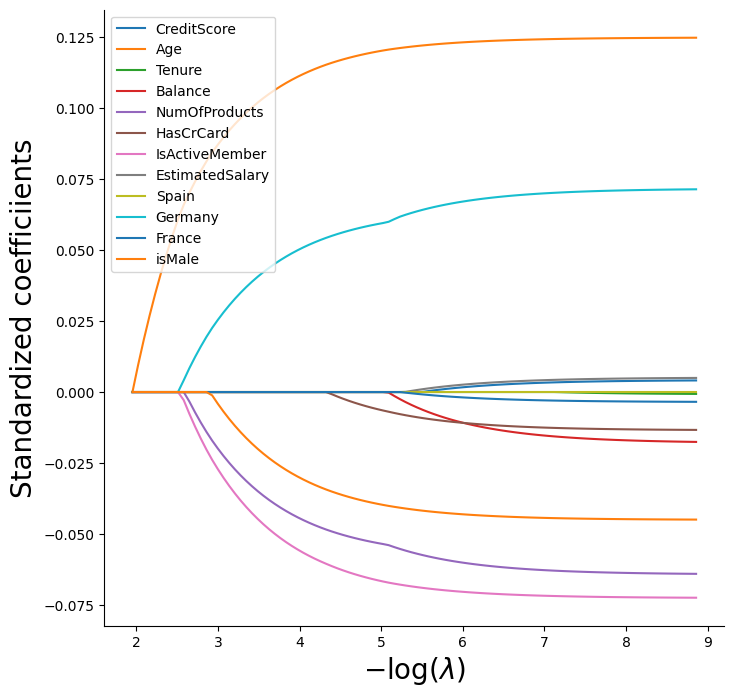

In [17]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);
sns.despine()

In [18]:
labels = ['Age', 'Germany', 'IsActiveMember', 'NumOfProducts', 'isMale']
X = train_dataset_copy[labels][:10000]
Y = train_dataset_copy['Exited'][:10000]

test_X = test_dataset_copy[labels]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
test_X_scaled = scaler.transform(test_X)

In [19]:
svm_model = SVC(kernel='linear', C=0.1)  # 커널을 'linear'로 설정

# # 교차 검증 실행
# cv_results = cross_validate(svm_model, X_scaled, Y, cv=5)

# # 교차 검증 성능 평가 (평균 R^2 값)
# cv_err = np.mean(cv_results['test_score'])
# print(f"평균 교차 검증 성능 (R^2): {cv_err}")

In [20]:
svm_model_fitted = svm_model.fit(X[:1000], Y[:1000])

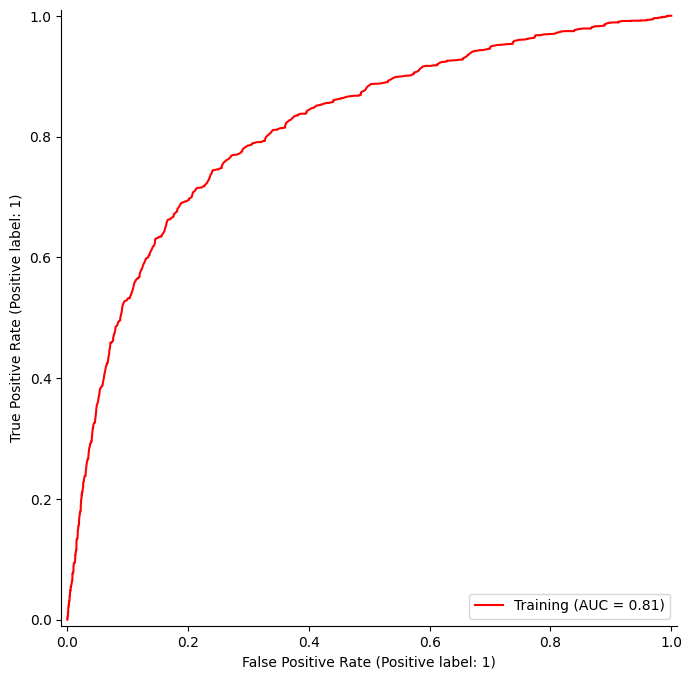

In [21]:
fig, ax = subplots(figsize=(8,8))
roc_curve(svm_model_fitted,
          X,
          Y,
          name='Training',
          color='r',
          ax=ax);
sns.despine()

In [22]:
svm_model_prob = SVC(kernel='linear', C=0.1, probability=True)
svm_model_prob_fitted = svm_model_prob.fit(X[:1000], Y[:1000])

In [23]:
probs = svm_model_prob_fitted.predict_proba(test_X)

In [24]:
probs.shape

(110023, 2)

In [25]:
probs[:6]

array([[0.9778494 , 0.0221506 ],
       [0.44608547, 0.55391453],
       [0.84267709, 0.15732291],
       [0.85751664, 0.14248336],
       [0.6713928 , 0.3286072 ],
       [0.95521861, 0.04478139]])

In [26]:
submission = test_dataset_copy['id'].copy()
new_column_df = pd.DataFrame(probs[:,1].copy(), columns=['Exited'])
new_column_df.shape

(110023, 1)

In [27]:
submission = pd.concat([submission, new_column_df], axis=1)
submission.shape

(110023, 2)

In [28]:
submission.head()

,id,Exited
0,165034,0.022151
1,165035,0.553915
2,165036,0.157323
3,165037,0.142483
4,165038,0.328607


In [29]:
submission.to_csv('submission.csv', index=False)